# London Neighbourhoods Segmentation Based on Primary School Ratings and Venue Categories 

## Introduction/Business Problem

London is the capital and largest city of England and United Kingdom. Beside that London is one of the financial capitals of the world. Therefore there are limitless of business opportunities this makes London very attractive for business professionals.

London is considered to be one of the world's most important global cities and has been called the world's most powerful,most desirable,most influential,most visited,most expensive,sustainable,most investment-friendly,and most-popular-for-work city. It exerts a considerable impact upon the arts, commerce, education, entertainment, fashion, finance, healthcare, media, professional services, research and development, tourism and transportation.London ranks 26th out of 300 major cities for economic performance.It is one of the largest financial centres and has either the fifth- or the sixth-largest metropolitan area GDP.

Many expats moving to London with their families need guidance according to their personal needs and family interests. As London is very big city, for the new comers it can be challenging to take correct decision for settlement. 

In this project a family with 2 kids is moving to London from US for business purposes. Their first priority on choosing a Neighbourhood is Primary School Education Rating and family friendly venues (Parks, Museums, Art galleries etc.). 

The purpose of the Project is to implement a recommendation engine to families with small kids which prefer to live in near of schools that has high education quality and family friendly places.




## Data Description

As the primary school ratings are highest priority for the family, I found Ofsted ratings of Primary schools in London from www.compare-school-performance.service.gov.uk as csv file.

The foursquare API was utilized to get the venues and categories in 500 m radius of each schools.

The Latitude and Longitude informations of the schools were taken by Geopy API.

There are 27 Boroughs and 1088 Primary Schools in London. The primary schools are categorized according to their Ofsted Ratings as 'Outstanding', 'Good' and 'Need Improvement'. I converted these Ratings to numerical values as 'Need Improvement'=1, 'Good'=2, 'Outstanding'=3.




In [189]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import pandas as pd

import numpy as np

import time

from geopy.geocoders import Nominatim

import seaborn as sns

In [2]:
df_raw=pd.read_excel('primaryschools.xlsx')

In [3]:
df_raw.head()

,Borough,School Name,STREET,LOCALITY,TOWN,POSTCODE,Ofsted Raiting
0,Camden,Argyle Primary School,Tonbridge Street,NaN,London,WC1H 9EG,Outstanding
1,Camden,Beckford Primary School,Dornfell Street,West Hampstead,London,NW6 1QL,Good
2,Camden,Brecknock Primary School,Cliff Villas,NaN,London,NW1 9AL,Outstanding
3,Camden,Brookfield Primary School,Chester Road,NaN,London,N19 5DH,Outstanding
4,Camden,Carlton Primary School,Grafton Road,NaN,London,NW5 4AX,Good


In [4]:
df_raw.drop('LOCALITY', axis=1, inplace=True) # LOCALITY Column is dropped as not relevant

In [5]:
df_raw

,Borough,School Name,STREET,TOWN,POSTCODE,Ofsted Raiting
0,Camden,Argyle Primary School,Tonbridge Street,London,WC1H 9EG,Outstanding
1,Camden,Beckford Primary School,Dornfell Street,London,NW6 1QL,Good
2,Camden,Brecknock Primary School,Cliff Villas,London,NW1 9AL,Outstanding
3,Camden,Brookfield Primary School,Chester Road,London,N19 5DH,Outstanding
4,Camden,Carlton Primary School,Grafton Road,London,NW5 4AX,Good
...,...,...,...,...,...,...
1084,Waltham Forest,Holy Family Catholic School,1 Shernhall Street,London,E17 3EA,Good
1085,Waltham Forest,Forest School,College Place,London,E17 3PY,Outstanding
1086,Haringey,Hyland House School,97 Holcombe Road,London,N17 9AB,Good
1087,Waltham Forest,Normanhurst School,68-74 Station Road,London,E4 7BA,Outstanding


In [9]:
len(df_raw.Borough.unique()) # There are 27 Boroughs in London

27

In [11]:
# adding Latitude and Longitude columns to dataframe
df_raw['Latitude']=0 
df_raw['Longitude']=0

In [12]:
df_raw

,Borough,School Name,STREET,TOWN,POSTCODE,Ofsted Raiting,Latitude,Longitude
0,Camden,Argyle Primary School,Tonbridge Street,London,WC1H 9EG,Outstanding,0,0
1,Camden,Beckford Primary School,Dornfell Street,London,NW6 1QL,Good,0,0
2,Camden,Brecknock Primary School,Cliff Villas,London,NW1 9AL,Outstanding,0,0
3,Camden,Brookfield Primary School,Chester Road,London,N19 5DH,Outstanding,0,0
4,Camden,Carlton Primary School,Grafton Road,London,NW5 4AX,Good,0,0
...,...,...,...,...,...,...,...,...
1084,Waltham Forest,Holy Family Catholic School,1 Shernhall Street,London,E17 3EA,Good,0,0
1085,Waltham Forest,Forest School,College Place,London,E17 3PY,Outstanding,0,0
1086,Haringey,Hyland House School,97 Holcombe Road,London,N17 9AB,Good,0,0
1087,Waltham Forest,Normanhurst School,68-74 Station Road,London,E4 7BA,Outstanding,0,0


In [13]:
# We need to convert Latitude and Longitude columns data from Integer to Float
df_raw = df_raw.astype({"Latitude": float,"Longitude": float})

In [15]:
df_raw.shape

(1089, 8)

In [16]:
len(df_raw)

1089

In [21]:
# Getting Longitude and Latitude data of Boroughs 


for i in range(0,len(df_raw)-1):
    
    address = '{},{}, London'.format(df_raw['STREET'].values[i],df_raw['POSTCODE'].values[i])
    
    geolocator = Nominatim(user_agent="london_explorer")
    
    location = geolocator.geocode(address)
    
    time.sleep(1) #geopy allows only 1 data per second, therefore we add sleep method
    
    if location is None:
        
        df_raw.at[i,'Latitude']=0
        df_raw.at[i,'Longitude']=0
        
    else:
        
        df_raw.at[i,'Latitude']=location.latitude
        df_raw.at[i,'Longitude']=location.longitude

In [26]:
df_raw

,Borough,School Name,STREET,TOWN,POSTCODE,Ofsted Raiting,Latitude,Longitude
0,Camden,Argyle Primary School,Tonbridge Street,London,WC1H 9EG,Outstanding,51.528269,-0.124216
1,Camden,Beckford Primary School,Dornfell Street,London,NW6 1QL,Good,51.550744,-0.200699
2,Camden,Brecknock Primary School,Cliff Villas,London,NW1 9AL,Outstanding,51.547195,-0.127931
3,Camden,Brookfield Primary School,Chester Road,London,N19 5DH,Outstanding,51.564050,-0.144480
4,Camden,Carlton Primary School,Grafton Road,London,NW5 4AX,Good,51.550833,-0.149670
...,...,...,...,...,...,...,...,...
1084,Waltham Forest,Holy Family Catholic School,1 Shernhall Street,London,E17 3EA,Good,51.589715,-0.007203
1085,Waltham Forest,Forest School,College Place,London,E17 3PY,Outstanding,51.585783,0.008178
1086,Haringey,Hyland House School,97 Holcombe Road,London,N17 9AB,Good,51.592695,-0.065981
1087,Waltham Forest,Normanhurst School,68-74 Station Road,London,E4 7BA,Outstanding,0.000000,0.000000


In [38]:
df_raw=df_raw[df_raw['Latitude']!=0]

#removing the raws with '0' inputs 
    

In [39]:
df_raw

,Borough,School Name,STREET,TOWN,POSTCODE,Ofsted Raiting,Latitude,Longitude
0,Camden,Argyle Primary School,Tonbridge Street,London,WC1H 9EG,Outstanding,51.528269,-0.124216
1,Camden,Beckford Primary School,Dornfell Street,London,NW6 1QL,Good,51.550744,-0.200699
2,Camden,Brecknock Primary School,Cliff Villas,London,NW1 9AL,Outstanding,51.547195,-0.127931
3,Camden,Brookfield Primary School,Chester Road,London,N19 5DH,Outstanding,51.564050,-0.144480
4,Camden,Carlton Primary School,Grafton Road,London,NW5 4AX,Good,51.550833,-0.149670
...,...,...,...,...,...,...,...,...
1082,Waltham Forest,Walthamstow School for Girls,Church Hill,London,E17 9RZ,Need Improvement,51.585760,-0.012516
1084,Waltham Forest,Holy Family Catholic School,1 Shernhall Street,London,E17 3EA,Good,51.589715,-0.007203
1085,Waltham Forest,Forest School,College Place,London,E17 3PY,Outstanding,51.585783,0.008178
1086,Haringey,Hyland House School,97 Holcombe Road,London,N17 9AB,Good,51.592695,-0.065981


In [40]:
# Transforming school ratings to numerical values
df_raw.replace(['Outstanding', 'Good','Need Improvement'],[3,2,1],inplace=True)

/Users/mertsolmaz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [41]:
df_raw

,Borough,School Name,STREET,TOWN,POSTCODE,Ofsted Raiting,Latitude,Longitude
0,Camden,Argyle Primary School,Tonbridge Street,London,WC1H 9EG,3,51.528269,-0.124216
1,Camden,Beckford Primary School,Dornfell Street,London,NW6 1QL,2,51.550744,-0.200699
2,Camden,Brecknock Primary School,Cliff Villas,London,NW1 9AL,3,51.547195,-0.127931
3,Camden,Brookfield Primary School,Chester Road,London,N19 5DH,3,51.564050,-0.144480
4,Camden,Carlton Primary School,Grafton Road,London,NW5 4AX,2,51.550833,-0.149670
...,...,...,...,...,...,...,...,...
1082,Waltham Forest,Walthamstow School for Girls,Church Hill,London,E17 9RZ,1,51.585760,-0.012516
1084,Waltham Forest,Holy Family Catholic School,1 Shernhall Street,London,E17 3EA,2,51.589715,-0.007203
1085,Waltham Forest,Forest School,College Place,London,E17 3PY,3,51.585783,0.008178
1086,Haringey,Hyland House School,97 Holcombe Road,London,N17 9AB,2,51.592695,-0.065981


In [53]:
CLIENT_ID = 'SGPWV12RGRME5PY04QQEMLITZHI2H00BM4JDWFLVWF21EFHE' # your Foursquare ID
CLIENT_SECRET = 'GBJP3PTSAGUXFZUGN5Q1LLU5X2MAQGCWPIDAKDFRHYGXAXR3' # your Foursquare Secret
VERSION = '20200725' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
LIMIT=100

urlstr='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'



Your credentails:
CLIENT_ID: SGPWV12RGRME5PY04QQEMLITZHI2H00BM4JDWFLVWF21EFHE
CLIENT_SECRET:GBJP3PTSAGUXFZUGN5Q1LLU5X2MAQGCWPIDAKDFRHYGXAXR3


In [54]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = urlstr.format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [55]:

london_venues=getNearbyVenues(names=df_raw['Borough'],latitudes=df_raw['Latitude'],longitudes=df_raw['Longitude'])

Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Camden
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenwich
Greenw

Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Barnet
Bexley
Bexley
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Brent
Bromley
Croydon
Croydon
Croydon
Croydon
Croydon
Croydon
Croydon
Croydon
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Ealing
Wandsworth
Ealing
Ealing
Ealing
Ealing
Haringey
Ealing
Ealing
Ealing
Ealing
Ealing
Enfield
Enfield
Enfield
Enfield
Enfiel

In [56]:
london_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Camden,51.528269,-0.124216,Patisserie Deux Amis,51.526798,-0.124189,Coffee Shop
1,Camden,51.528269,-0.124216,St. Pancras Renaissance Hotel London,51.529733,-0.125912,Hotel
2,Camden,51.528269,-0.124216,Pitted Olive,51.526369,-0.125623,Turkish Restaurant
3,Camden,51.528269,-0.124216,Origin Coffee Roasters,51.529133,-0.126618,Coffee Shop
4,Camden,51.528269,-0.124216,The Sir John Ritblat Gallery: Treasures of the...,51.529666,-0.127541,Museum
...,...,...,...,...,...,...,...
27921,Barnet,51.539071,-0.148149,Gloucester Gate,51.535120,-0.148409,Park
27922,Barnet,51.539071,-0.148149,St. Pancras Fountain,51.535442,-0.147471,Fountain
27923,Barnet,51.539071,-0.148149,Camden chanel,51.537023,-0.153885,Harbor / Marina
27924,Barnet,51.539071,-0.148149,Gloucester Gate Playground,51.534912,-0.148967,Playground


In [62]:
london_venues.rename(columns={'Neighborhood':'Borough'}, inplace=True)

In [71]:
df_gr=df_raw.groupby('Borough').mean().reset_index()

In [72]:
df_gr # grouping thr Boroughs according to school ratings

,Borough,Ofsted Raiting,Latitude,Longitude
0,Barnet,1.984848,51.448226,-1.286293
1,Bexley,2.500000,51.473024,0.101975
2,Brent,2.275000,51.552885,-0.242371
3,Bromley,2.000000,51.436560,0.039432
4,Camden,2.013889,51.544701,-0.154245
5,Croydon,2.000000,51.414159,-0.098601
6,Ealing,2.131579,51.514452,-0.298512
7,Enfield,2.000000,51.626284,-0.101255
8,Greenwich,2.000000,51.475065,0.049342
9,Hackney,1.879310,51.554432,-0.066408


In [221]:
df_pl=df_gr.drop(['Latitude'],1)

In [222]:
df_pl.drop(['Longitude'],1,inplace=True)

In [235]:
df_pl.head()

,Borough,Ofsted Raiting
0,Barnet,1.984848
1,Bexley,2.500000
2,Brent,2.275000
3,Bromley,2.000000
4,Camden,2.013889


In [210]:
import matplotlib.pyplot as plt
%matplotlib inline

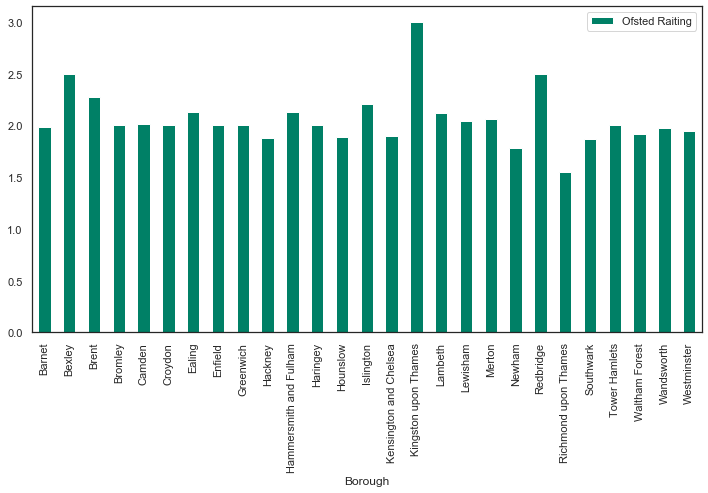

In [258]:
df_pl.plot(x='Borough',kind='bar',colormap='summer',figsize=(12,6))

In [63]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Borough'] = london_venues['Borough'] 

# move neighborhood column to the first column
fixed_columns = ['Borough'] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot

,Borough,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,...,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Camden,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Camden,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Camden,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Camden,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Camden,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27921,Barnet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27922,Barnet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27923,Barnet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27924,Barnet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
london_group=london_onehot.groupby('Borough').mean().reset_index()

In [70]:
london_group

,Borough,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,...,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Barnet,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001366,0.000000,0.000000,0.001366,0.000000,0.001366
1,Bexley,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Brent,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.002597,0.000000,0.000000,0.000000,0.000000,0.010390,0.000000,0.000000
3,Bromley,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Camden,0.000000,0.000309,0.000309,0.000000,0.000309,0.000617,0.002468,0.000000,0.000000,...,0.000000,0.003085,0.001543,0.000309,0.001851,0.000000,0.000000,0.002777,0.000309,0.004320
5,Croydon,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Ealing,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007924,0.000000,0.000000,...,0.000000,0.001585,0.004754,0.000000,0.000000,0.000000,0.000000,0.001585,0.000000,0.000000
7,Enfield,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003436,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Greenwich,0.000000,0.000000,0.000000,0.000000,0.000000,0.003597,0.001799,0.000000,0.000000,...,0.000000,0.001799,0.001799,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001799
9,Hackney,0.000000,0.000000,0.000597,0.000000,0.000000,0.000000,0.001193,0.000000,0.000000,...,0.000000,0.006563,0.005967,0.000597,0.000000,0.000000,0.003580,0.018496,0.000000,0.000000


In [120]:
#combining the school rating table with venues table 
london_vs = pd.merge(left=london_group, right=df_gr[['Borough','Ofsted Raiting']], how='left', left_on='Borough', right_on='Borough')

In [121]:
london_vs

,Borough,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit,Ofsted Raiting
0,Barnet,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.001366,0.000000,0.000000,0.001366,0.000000,0.001366,1.984848
1,Bexley,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000
2,Brent,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.002597,0.000000,0.000000,0.000000,0.000000,0.010390,0.000000,0.000000,2.275000
3,Bromley,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
4,Camden,0.000000,0.000309,0.000309,0.000000,0.000309,0.000617,0.002468,0.000000,0.000000,...,0.003085,0.001543,0.000309,0.001851,0.000000,0.000000,0.002777,0.000309,0.004320,2.013889
5,Croydon,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
6,Ealing,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007924,0.000000,0.000000,...,0.001585,0.004754,0.000000,0.000000,0.000000,0.000000,0.001585,0.000000,0.000000,2.131579
7,Enfield,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003436,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
8,Greenwich,0.000000,0.000000,0.000000,0.000000,0.000000,0.003597,0.001799,0.000000,0.000000,...,0.001799,0.001799,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001799,2.000000
9,Hackney,0.000000,0.000000,0.000597,0.000000,0.000000,0.000000,0.001193,0.000000,0.000000,...,0.006563,0.005967,0.000597,0.000000,0.000000,0.003580,0.018496,0.000000,0.000000,1.879310


In [123]:
column_names=london_vs.columns

In [124]:
column_names=column_names[:-1]

In [125]:
column_names=column_names.insert(1,'Ofsted Raiting')

In [126]:
column_names

Index(['Borough', 'Ofsted Raiting', 'ATM', 'Accessories Store',
       'Adult Boutique', 'Advertising Agency', 'Afghan Restaurant',
       'African Restaurant', 'American Restaurant', 'Animal Shelter',
       ...
       'Windmill', 'Wine Bar', 'Wine Shop', 'Wings Joint', 'Women's Store',
       'Xinjiang Restaurant', 'Yakitori Restaurant', 'Yoga Studio', 'Zoo',
       'Zoo Exhibit'],
      dtype='object', length=438)

In [127]:
london_vs=london_vs.reindex(columns=column_names)

In [318]:
london_vs.head()

,Borough,Ofsted Rating Average per Borough,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,...,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Barnet,1.984848,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.001366,0.0,0.0,0.001366,0.000000,0.001366
1,Bexley,2.500000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
2,Brent,2.275000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.002597,0.000000,0.000000,0.0,0.0,0.010390,0.000000,0.000000
3,Bromley,2.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
4,Camden,2.013889,0.0,0.000309,0.000309,0.0,0.000309,0.000617,0.002468,0.0,...,0.0,0.003085,0.001543,0.000309,0.001851,0.0,0.0,0.002777,0.000309,0.004320


In [131]:
london_vs.rename(columns={'Ofsted Rating Average per Venue':'Ofsted Rating Average per Borough'}, inplace=True)

In [316]:
london_vs.head()

,Borough,Ofsted Rating Average per Borough,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,...,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Barnet,1.984848,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.001366,0.0,0.0,0.001366,0.000000,0.001366
1,Bexley,2.500000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
2,Brent,2.275000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.002597,0.000000,0.000000,0.0,0.0,0.010390,0.000000,0.000000
3,Bromley,2.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
4,Camden,2.013889,0.0,0.000309,0.000309,0.0,0.000309,0.000617,0.002468,0.0,...,0.0,0.003085,0.001543,0.000309,0.001851,0.0,0.0,0.002777,0.000309,0.004320


In [256]:
num_top_venues = 5

for hood in london_vs['Borough']:
    print("|---------"+hood+"---------|")
    print('Average school rating')
    print(london_vs[london_vs['Borough'] == hood].T.values[1])
    temp = london_vs[london_vs['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

|---------Barnet---------|
Average school rating
[1.9848484848484849]
           venue  freq
0  Grocery Store  0.07
1           Café  0.07
2    Coffee Shop  0.07
3            Pub  0.05
4           Park  0.04


|---------Bexley---------|
Average school rating
[2.5]
                venue  freq
0                Café  0.25
1       Grocery Store  0.25
2  Italian Restaurant  0.12
3           Nightclub  0.12
4   Convenience Store  0.12


|---------Brent---------|
Average school rating
[2.275]
           venue  freq
0           Café  0.06
1    Coffee Shop  0.06
2           Park  0.05
3  Grocery Store  0.04
4         Bakery  0.04


|---------Bromley---------|
Average school rating
[2.0]
                  venue  freq
0             Pet Store  0.25
1     Convenience Store  0.25
2  Gym / Fitness Center  0.25
3       Motorcycle Shop  0.25
4                   ATM  0.00


|---------Camden---------|
Average school rating
[2.013888888888889]
                venue  freq
0                Café  0.06
1     

In [160]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [163]:
london_grouped=london_vs.drop(['Ofsted Rating Average per Borough'],axis=1)

In [164]:
london_grouped

,Borough,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,...,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Barnet,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001366,0.000000,0.000000,0.001366,0.000000,0.001366
1,Bexley,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Brent,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.002597,0.000000,0.000000,0.000000,0.000000,0.010390,0.000000,0.000000
3,Bromley,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Camden,0.000000,0.000309,0.000309,0.000000,0.000309,0.000617,0.002468,0.000000,0.000000,...,0.000000,0.003085,0.001543,0.000309,0.001851,0.000000,0.000000,0.002777,0.000309,0.004320
5,Croydon,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Ealing,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007924,0.000000,0.000000,...,0.000000,0.001585,0.004754,0.000000,0.000000,0.000000,0.000000,0.001585,0.000000,0.000000
7,Enfield,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003436,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Greenwich,0.000000,0.000000,0.000000,0.000000,0.000000,0.003597,0.001799,0.000000,0.000000,...,0.000000,0.001799,0.001799,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001799
9,Hackney,0.000000,0.000000,0.000597,0.000000,0.000000,0.000000,0.001193,0.000000,0.000000,...,0.000000,0.006563,0.005967,0.000597,0.000000,0.000000,0.003580,0.018496,0.000000,0.000000


In [168]:

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = london_grouped['Borough']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barnet,Café,Grocery Store,Coffee Shop,Pub,Park,Pizza Place,Supermarket,Bus Stop,Turkish Restaurant,Indian Restaurant
1,Bexley,Grocery Store,Café,Italian Restaurant,Nightclub,Home Service,Convenience Store,Zoo Exhibit,Film Studio,Filipino Restaurant,Field
2,Brent,Coffee Shop,Café,Park,Pub,Grocery Store,Bakery,Supermarket,Indian Restaurant,Fast Food Restaurant,Gym / Fitness Center
3,Bromley,Motorcycle Shop,Pet Store,Convenience Store,Gym / Fitness Center,Zoo Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
4,Camden,Café,Coffee Shop,Pub,Italian Restaurant,Bakery,Grocery Store,Pizza Place,Hotel,Sandwich Place,Indian Restaurant


In [ ]:
london_vs['Ofsted Rating Average per Borough']

In [169]:
neighborhoods_venues_sorted.insert(1, 'School Rating Average per Borough',london_vs['Ofsted Rating Average per Borough'] )

In [317]:
neighborhoods_venues_sorted.head()

,Borough,Cluster Type,School Rating Average per Borough,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barnet,4,1.984848,51.448226,-1.286293,Café,Grocery Store,Coffee Shop,Pub,Park,Pizza Place,Supermarket,Bus Stop,Turkish Restaurant,Indian Restaurant
1,Bexley,2,2.500000,51.473024,0.101975,Grocery Store,Café,Italian Restaurant,Nightclub,Home Service,Convenience Store,Zoo Exhibit,Film Studio,Filipino Restaurant,Field
2,Brent,2,2.275000,51.552885,-0.242371,Coffee Shop,Café,Park,Pub,Grocery Store,Bakery,Supermarket,Indian Restaurant,Fast Food Restaurant,Gym / Fitness Center
3,Bromley,3,2.000000,51.436560,0.039432,Motorcycle Shop,Pet Store,Convenience Store,Gym / Fitness Center,Zoo Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
4,Camden,4,2.013889,51.544701,-0.154245,Café,Coffee Shop,Pub,Italian Restaurant,Bakery,Grocery Store,Pizza Place,Hotel,Sandwich Place,Indian Restaurant


In [171]:
# set number of clusters
kclusters = 5

london_vs_clustering = london_vs.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_vs_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 2, 2, 3, 4, 4, 4, 4, 4, 0], dtype=int32)

In [330]:
data=london_vs_clustering

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
Name: clusters, dtype: int32
0     0
1     1
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    1
16    0
17    0
18    0
19    0
20    1
21    0
22    0
23    0
24    0
25    0
26    0
Name: clusters, dtype: int32
0     0
1     1
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    2
16    0
17    0
18    0
19    0
20    1
21    0
22    0
23    0
24    0
25    0
26    0
Name: clusters, dtype: int32
0     3
1     1
2     3
3     0
4     3
5     3
6     3
7     3
8     3
9     0
10    3
11    3
12    0
13    3
14    0
15    2
16    3
17    3
18    3
19    0
20    1
21    0
22    0
23    3
24    0
25    3
26    0
Name: clusters, dtype: int32
0     1
1     2
2   

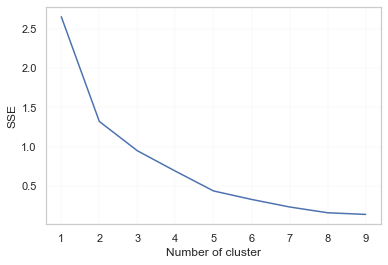

In [331]:
#elbow method to check which cluster number is the best
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [172]:
kmeans.labels_

array([4, 2, 2, 3, 4, 4, 4, 4, 4, 0, 4, 4, 0, 4, 0, 1, 4, 4, 4, 0, 2, 0,
       0, 4, 0, 4, 4], dtype=int32)

In [174]:
neighborhoods_venues_sorted.insert(1, 'Cluster Type',kmeans.labels_ )

In [175]:
neighborhoods_venues_sorted

,Borough,Cluster Type,School Rating Average per Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barnet,4,1.984848,Café,Grocery Store,Coffee Shop,Pub,Park,Pizza Place,Supermarket,Bus Stop,Turkish Restaurant,Indian Restaurant
1,Bexley,2,2.500000,Grocery Store,Café,Italian Restaurant,Nightclub,Home Service,Convenience Store,Zoo Exhibit,Film Studio,Filipino Restaurant,Field
2,Brent,2,2.275000,Coffee Shop,Café,Park,Pub,Grocery Store,Bakery,Supermarket,Indian Restaurant,Fast Food Restaurant,Gym / Fitness Center
3,Bromley,3,2.000000,Motorcycle Shop,Pet Store,Convenience Store,Gym / Fitness Center,Zoo Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
4,Camden,4,2.013889,Café,Coffee Shop,Pub,Italian Restaurant,Bakery,Grocery Store,Pizza Place,Hotel,Sandwich Place,Indian Restaurant
5,Croydon,4,2.000000,Park,Pub,Grocery Store,Chinese Restaurant,Supermarket,Lake,Bakery,Clothing Store,Fast Food Restaurant,Fried Chicken Joint
6,Ealing,4,2.131579,Coffee Shop,Pub,Grocery Store,Park,Café,Pizza Place,Bakery,Indian Restaurant,Bus Stop,Gym / Fitness Center
7,Enfield,4,2.000000,Grocery Store,Pub,Coffee Shop,Turkish Restaurant,Pizza Place,Bus Stop,Fast Food Restaurant,Café,Supermarket,Italian Restaurant
8,Greenwich,4,2.000000,Pub,Grocery Store,Café,Bus Stop,Coffee Shop,Fast Food Restaurant,Indian Restaurant,Park,Supermarket,Pharmacy
9,Hackney,0,1.879310,Café,Pub,Coffee Shop,Grocery Store,Pizza Place,Cocktail Bar,Park,Bakery,Bar,Yoga Studio


In [176]:
neighborhoods_venues_sorted.insert(3, 'Latitude',df_gr['Latitude'] )

In [177]:
neighborhoods_venues_sorted.insert(4, 'Longitude',df_gr['Longitude'] )

In [178]:
neighborhoods_venues_sorted

,Borough,Cluster Type,School Rating Average per Borough,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barnet,4,1.984848,51.448226,-1.286293,Café,Grocery Store,Coffee Shop,Pub,Park,Pizza Place,Supermarket,Bus Stop,Turkish Restaurant,Indian Restaurant
1,Bexley,2,2.500000,51.473024,0.101975,Grocery Store,Café,Italian Restaurant,Nightclub,Home Service,Convenience Store,Zoo Exhibit,Film Studio,Filipino Restaurant,Field
2,Brent,2,2.275000,51.552885,-0.242371,Coffee Shop,Café,Park,Pub,Grocery Store,Bakery,Supermarket,Indian Restaurant,Fast Food Restaurant,Gym / Fitness Center
3,Bromley,3,2.000000,51.436560,0.039432,Motorcycle Shop,Pet Store,Convenience Store,Gym / Fitness Center,Zoo Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
4,Camden,4,2.013889,51.544701,-0.154245,Café,Coffee Shop,Pub,Italian Restaurant,Bakery,Grocery Store,Pizza Place,Hotel,Sandwich Place,Indian Restaurant
5,Croydon,4,2.000000,51.414159,-0.098601,Park,Pub,Grocery Store,Chinese Restaurant,Supermarket,Lake,Bakery,Clothing Store,Fast Food Restaurant,Fried Chicken Joint
6,Ealing,4,2.131579,51.514452,-0.298512,Coffee Shop,Pub,Grocery Store,Park,Café,Pizza Place,Bakery,Indian Restaurant,Bus Stop,Gym / Fitness Center
7,Enfield,4,2.000000,51.626284,-0.101255,Grocery Store,Pub,Coffee Shop,Turkish Restaurant,Pizza Place,Bus Stop,Fast Food Restaurant,Café,Supermarket,Italian Restaurant
8,Greenwich,4,2.000000,51.475065,0.049342,Pub,Grocery Store,Café,Bus Stop,Coffee Shop,Fast Food Restaurant,Indian Restaurant,Park,Supermarket,Pharmacy
9,Hackney,0,1.879310,51.554432,-0.066408,Café,Pub,Coffee Shop,Grocery Store,Pizza Place,Cocktail Bar,Park,Bakery,Bar,Yoga Studio


In [183]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Type']==0]

,Borough,Cluster Type,School Rating Average per Borough,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Hackney,0,1.879310,51.554432,-0.066408,Café,Pub,Coffee Shop,Grocery Store,Pizza Place,Cocktail Bar,Park,Bakery,Bar,Yoga Studio
12,Hounslow,0,1.888889,51.488141,-0.277187,Pub,Café,Italian Restaurant,Bakery,Park,Restaurant,Coffee Shop,Juice Bar,Indian Restaurant,Grocery Store
14,Kensington and Chelsea,0,1.897959,51.296485,-1.653542,Hotel,Italian Restaurant,Café,Pub,Bakery,Coffee Shop,Pizza Place,Grocery Store,Restaurant,Gym / Fitness Center
19,Newham,0,1.783784,51.538054,0.031856,Grocery Store,Indian Restaurant,Park,Hotel,Café,Pub,Fast Food Restaurant,Supermarket,Gym,Sandwich Place
21,Richmond upon Thames,0,1.545455,51.481977,-0.226136,Pub,Coffee Shop,Theater,Café,Restaurant,Hotel,Grocery Store,Pizza Place,Burger Joint,Cocktail Bar
22,Southwark,0,1.867647,51.481362,-0.082506,Pub,Coffee Shop,Café,Park,Grocery Store,Italian Restaurant,Bus Stop,Bar,Hotel,Gym / Fitness Center
24,Waltham Forest,0,1.920000,51.582240,-0.013544,Pub,Park,Café,Grocery Store,Coffee Shop,Convenience Store,Restaurant,Pizza Place,Fast Food Restaurant,Italian Restaurant


In [184]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Type']==1]

,Borough,Cluster Type,School Rating Average per Borough,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Kingston upon Thames,1,3.0,51.428056,-0.260609,Bar,Sandwich Place,Soccer Field,Coffee Shop,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market


In [185]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Type']==2]

,Borough,Cluster Type,School Rating Average per Borough,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bexley,2,2.500,51.473024,0.101975,Grocery Store,Café,Italian Restaurant,Nightclub,Home Service,Convenience Store,Zoo Exhibit,Film Studio,Filipino Restaurant,Field
2,Brent,2,2.275,51.552885,-0.242371,Coffee Shop,Café,Park,Pub,Grocery Store,Bakery,Supermarket,Indian Restaurant,Fast Food Restaurant,Gym / Fitness Center
20,Redbridge,2,2.500,51.578803,0.027589,Pub,Grocery Store,Restaurant,Café,Pizza Place,Park,Italian Restaurant,Coffee Shop,Pharmacy,English Restaurant


In [186]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Type']==3]

,Borough,Cluster Type,School Rating Average per Borough,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Bromley,3,2.0,51.43656,0.039432,Motorcycle Shop,Pet Store,Convenience Store,Gym / Fitness Center,Zoo Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


In [187]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Type']==4]

,Borough,Cluster Type,School Rating Average per Borough,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barnet,4,1.984848,51.448226,-1.286293,Café,Grocery Store,Coffee Shop,Pub,Park,Pizza Place,Supermarket,Bus Stop,Turkish Restaurant,Indian Restaurant
4,Camden,4,2.013889,51.544701,-0.154245,Café,Coffee Shop,Pub,Italian Restaurant,Bakery,Grocery Store,Pizza Place,Hotel,Sandwich Place,Indian Restaurant
5,Croydon,4,2.000000,51.414159,-0.098601,Park,Pub,Grocery Store,Chinese Restaurant,Supermarket,Lake,Bakery,Clothing Store,Fast Food Restaurant,Fried Chicken Joint
6,Ealing,4,2.131579,51.514452,-0.298512,Coffee Shop,Pub,Grocery Store,Park,Café,Pizza Place,Bakery,Indian Restaurant,Bus Stop,Gym / Fitness Center
7,Enfield,4,2.000000,51.626284,-0.101255,Grocery Store,Pub,Coffee Shop,Turkish Restaurant,Pizza Place,Bus Stop,Fast Food Restaurant,Café,Supermarket,Italian Restaurant
8,Greenwich,4,2.000000,51.475065,0.049342,Pub,Grocery Store,Café,Bus Stop,Coffee Shop,Fast Food Restaurant,Indian Restaurant,Park,Supermarket,Pharmacy
10,Hammersmith and Fulham,4,2.131579,51.495249,-0.223585,Pub,Café,Coffee Shop,Italian Restaurant,Grocery Store,Hotel,Park,Indian Restaurant,Bakery,Thai Restaurant
11,Haringey,4,2.000000,51.588050,-0.106376,Pub,Café,Coffee Shop,Turkish Restaurant,Grocery Store,Bakery,Bus Stop,Pizza Place,Park,Bar
13,Islington,4,2.209302,51.547052,-0.110370,Pub,Café,Coffee Shop,Park,Italian Restaurant,Gym / Fitness Center,Pizza Place,Grocery Store,Bar,Vietnamese Restaurant
16,Lambeth,4,2.116667,51.456383,-0.119054,Pub,Café,Coffee Shop,Park,Grocery Store,Pizza Place,Indian Restaurant,Gym / Fitness Center,Restaurant,Italian Restaurant


In [328]:
lon_lat=51.509865
lon_long=-0.118092

# create map
map_clusters = folium.Map(location=[lon_lat, lon_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_venues_sorted['Latitude'], neighborhoods_venues_sorted['Longitude'], neighborhoods_venues_sorted['Borough'], neighborhoods_venues_sorted['Cluster Type']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [329]:
lon_lat=51.509865
lon_long=-0.118092

# create map
map_clusters = folium.Map(location=[lon_lat, lon_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, rating in zip(neighborhoods_venues_sorted['Latitude'], neighborhoods_venues_sorted['Longitude'], neighborhoods_venues_sorted['Borough'], neighborhoods_venues_sorted['Cluster Type'], neighborhoods_venues_sorted['School Rating Average per Borough']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster)+' School rating average '+str(rating), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

In [259]:
df_raw.T

,0,1,2,3,4,5,6,7,8,9,...,1076,1077,1079,1080,1081,1082,1084,1085,1086,1088
Borough,Camden,Camden,Camden,Camden,Camden,Camden,Camden,Camden,Camden,Camden,...,Waltham Forest,Waltham Forest,Waltham Forest,Waltham Forest,Waltham Forest,Waltham Forest,Waltham Forest,Waltham Forest,Haringey,Barnet
School Name,Argyle Primary School,Beckford Primary School,Brecknock Primary School,Brookfield Primary School,Carlton Primary School,Edith Neville Primary School,Fleet Primary School,Hawley Primary School,Netley Primary School & Centre for Autism,New End Primary School,...,St Joseph's Catholic Infant School,Frederick Bremer School,Heathcote School & Science College,Willowfield School,Leytonstone School,Walthamstow School for Girls,Holy Family Catholic School,Forest School,Hyland House School,St Mary's and St John's CofE School
STREET,Tonbridge Street,Dornfell Street,Cliff Villas,Chester Road,Grafton Road,174 Ossulston Street,Fleet Road,Hawley Road,74 Stanhope Street,Streatley Place,...,Marsh Lane,Siddeley Road,Normanton Park,209 Blackhorse Road,Colworth Road,Church Hill,1 Shernhall Street,College Place,97 Holcombe Road,Bennett House
TOWN,London,London,London,London,London,London,London,London,London,London,...,London,London,London,London,London,London,London,London,London,London
POSTCODE,WC1H 9EG,NW6 1QL,NW1 9AL,N19 5DH,NW5 4AX,NW1 1DN,NW3 2QT,NW1 8RP,NW1 3EX,NW3 1HU,...,E10 7BL,E17 4EY,E4 6ES,E17 6ND,E11 1JD,E17 9RZ,E17 3EA,E17 3PY,N17 9AB,NW4 4QR
Ofsted Raiting,3,2,3,3,2,3,2,2,2,1,...,1,3,3,1,2,1,2,3,2,3
Latitude,51.5283,51.5507,51.5472,51.5641,51.5508,51.5316,51.5541,51.5428,51.5271,51.5579,...,51.5655,51.5946,51.6232,51.5861,51.573,51.5858,51.5897,51.5858,51.5927,51.5391
Longitude,-0.124216,-0.200699,-0.127931,-0.14448,-0.14967,-0.130584,-0.164826,-0.143143,-0.140823,-0.177334,...,-0.0217277,-0.0046339,0.0105369,-0.0409837,0.009288,-0.0125165,-0.00720269,0.0081778,-0.0659815,-0.148149


In [260]:
df_raw

,Borough,School Name,STREET,TOWN,POSTCODE,Ofsted Raiting,Latitude,Longitude
0,Camden,Argyle Primary School,Tonbridge Street,London,WC1H 9EG,3,51.528269,-0.124216
1,Camden,Beckford Primary School,Dornfell Street,London,NW6 1QL,2,51.550744,-0.200699
2,Camden,Brecknock Primary School,Cliff Villas,London,NW1 9AL,3,51.547195,-0.127931
3,Camden,Brookfield Primary School,Chester Road,London,N19 5DH,3,51.564050,-0.144480
4,Camden,Carlton Primary School,Grafton Road,London,NW5 4AX,2,51.550833,-0.149670
...,...,...,...,...,...,...,...,...
1082,Waltham Forest,Walthamstow School for Girls,Church Hill,London,E17 9RZ,1,51.585760,-0.012516
1084,Waltham Forest,Holy Family Catholic School,1 Shernhall Street,London,E17 3EA,2,51.589715,-0.007203
1085,Waltham Forest,Forest School,College Place,London,E17 3PY,3,51.585783,0.008178
1086,Haringey,Hyland House School,97 Holcombe Road,London,N17 9AB,2,51.592695,-0.065981


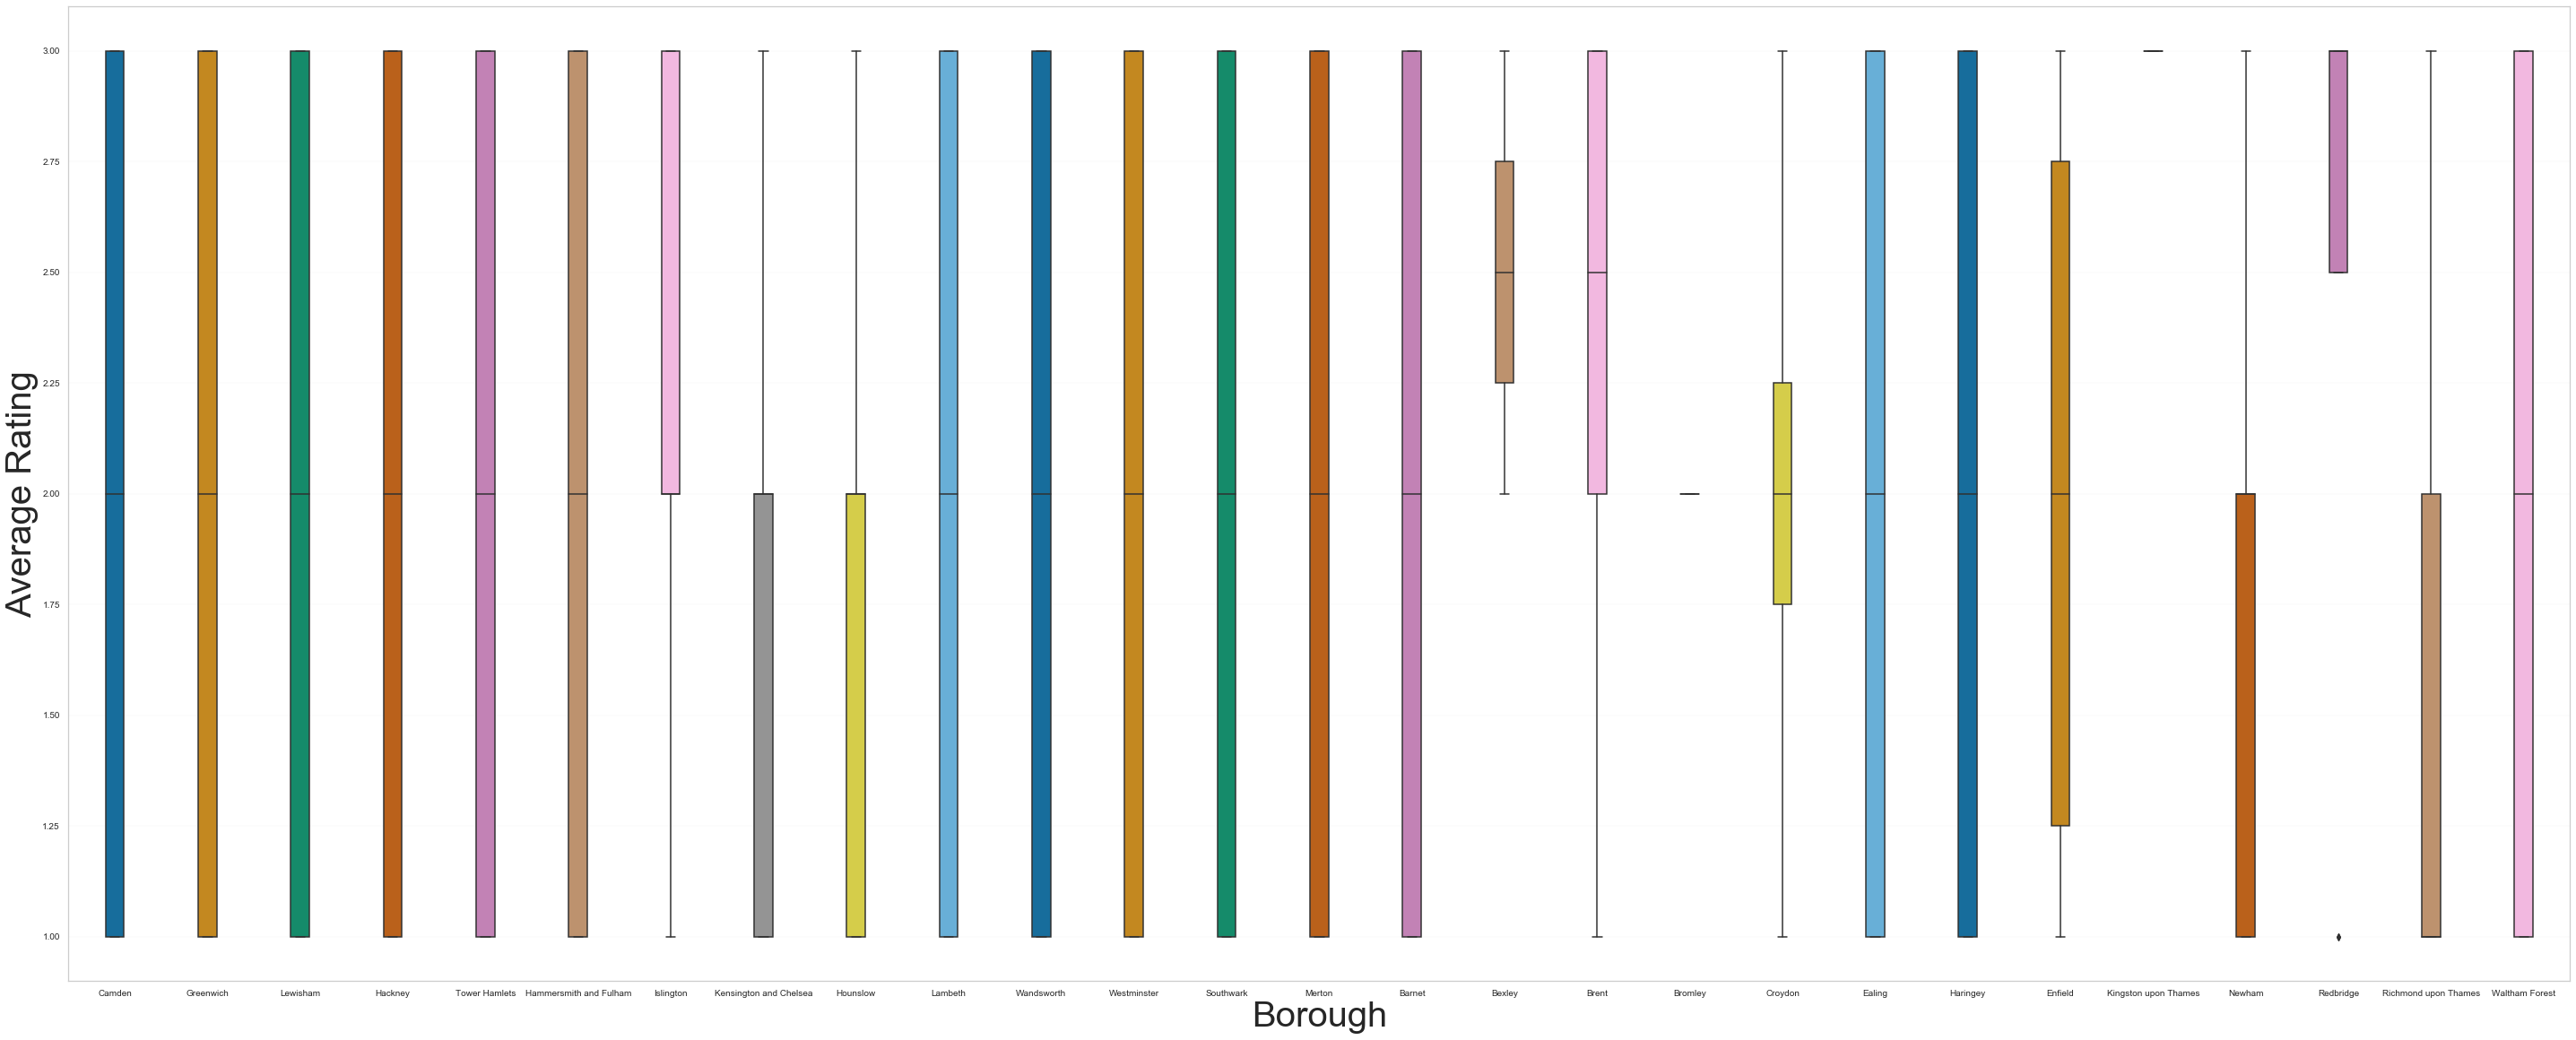

In [307]:
sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
fig_dims = (50, 20)
fig, ax = plt.subplots(figsize=fig_dims)

bplot=sns.boxplot(x='Borough', y='Ofsted Raiting', 
                 data=df_raw,
                 width=0.2,
                 palette="colorblind",ax=ax)

bplot.set_xlabel("Borough",fontsize=40)
bplot.set_ylabel("Average Rating",fontsize=40)
bplot.tick_params(labelsize=10)
